<a href="https://colab.research.google.com/github/shreya0202/CTScanImageClassification/blob/main/CTScanImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mounting Google Drive to get the dataset folder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#importing all the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import fnmatch
import pandas as pd
from sklearn.model_selection import train_test_split
import PIL
import os
import os.path
from PIL import Image
from numpy import asarray
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

import glob
import matplotlib
import imageio as im
from keras import models
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

import pickle

In [ ]:
#setting path of the dataset 
path = "/content/drive/My Drive/DS3/"

In [ ]:
#resizing images and storing in a list - Preprocessing Step 1

import time
start_time = time.time()
X = []
count = 0
for file in os.listdir(path):
    f_img = path+"/"+file
    img = Image.open(f_img)
    img = img.resize((32,32))
    X.append(np.array(img))
    count += 1
    print("Resized: ", count)

end_time = time.time()

time_seconds = (end_time - start_time)
print('\n\nTime taken : {} seconds'.format(time_seconds))

In [ ]:
# Display Images
def display(a, b, title1, title2):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [ ]:
#extracting classes and storing in the target list
classes = ['Abdomen', 'Chest', 'Head']
Y = []
import glob
res = []
for c in classes:
    for name in glob.glob(path+'/*'):
      if c in name:
        res = c
        Y.append(res)


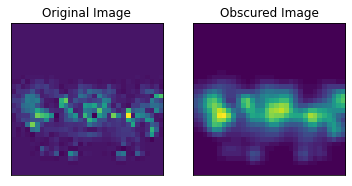

In [ ]:
#removing noise using image smoothing via Gaussian Filtering approach - Preprocessing Step 2
denoise = []
for i in range(len(X)):
    blur = cv2.GaussianBlur(X[i], (5, 5), 0)
    denoise.append(blur)

display(X[1], denoise[1], 'Original Image', 'Obscured Image')

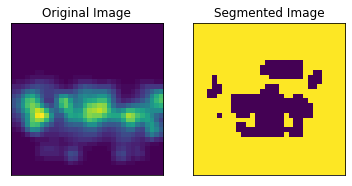

In [ ]:
# Image Segmentation - Preprocessing Step 3
X_segm = []
for i in range(len(denoise)):
  ret, thresh = cv2.threshold(denoise[i], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  X_segm.append(thresh)

X_segm = np.array(X_segm)
# Displaying segmented image
display(denoise[1], thresh, 'Original Image', 'Segmented Image')

In [ ]:
#converting to np array
X = np.array(X_segm)
Y = np.array(Y)

In [ ]:
#train test split into 70:30 ratio
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2], 1))
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3, random_state = 2000)

In [ ]:
#Building a 2D Convolution Neural Network model
model = Sequential()

#Convolution
model.add(Conv2D(32, (3, 3), input_shape = (32,32,1), activation = 'relu')) 
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), name='pool1'))
model.add(Dropout(0.5)) 

# 2nd layer
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), name='pool2'))
model.add(Dropout(0.5))

# Flattening
model.add(Flatten())

# Fully Connected layer
model.add(Dense(units=200, name='dense1', activation = 'relu'))
model.add(Dropout(0.3)) 
model.add(Dense(units=64, name='dense2', activation = 'relu'))
model.add(Dropout(0.3)) 
model.add(Dense(units=3, name='output', activation = 'softmax'))

layer1 = 'dense1'
layer2 = 'dense2'
out_layer = 'output'

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 10, 10, 256)       295168    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 5, 5, 256)       

In [ ]:
#Code for Stratified K-fold Cross Validation for 2D CNN
from sklearn.model_selection import StratifiedKFold

#splitting data into 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(x_train, y_train)

foldNum=0
for train_index, val_index in skf.split(x_train, y_train):
    foldNum+=1
    print("Results for fold",foldNum)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    #Model Training for CNN
    encoder = LabelBinarizer()
    train_y = encoder.fit_transform(Y_train)
    val_y = encoder.transform(Y_val)

    history = model.fit(X_train, train_y,
                        epochs=20,
                        batch_size=1024,
                        shuffle=True,
                        validation_data = (X_val,val_y))

Results for fold 1
Epoch 1/20
1/1 [==============================] - 0s 449ms/step - loss: 20.4526 - acc: 0.4476 - val_loss: 24.7845 - val_acc: 0.4762
Epoch 2/20
1/1 [==============================] - 0s 68ms/step - loss: 54.2921 - acc: 0.4619 - val_loss: 3.4871 - val_acc: 0.4762
Epoch 3/20
1/1 [==============================] - 0s 68ms/step - loss: 9.8188 - acc: 0.4810 - val_loss: 1.5509 - val_acc: 0.6095
Epoch 4/20
1/1 [==============================] - 0s 71ms/step - loss: 6.2269 - acc: 0.5095 - val_loss: 1.1552 - val_acc: 0.5048
Epoch 5/20
1/1 [==============================] - 0s 68ms/step - loss: 4.1202 - acc: 0.5321 - val_loss: 1.0223 - val_acc: 0.4762
Epoch 6/20
1/1 [==============================] - 0s 72ms/step - loss: 2.8602 - acc: 0.5095 - val_loss: 0.8529 - val_acc: 0.4762
Epoch 7/20
1/1 [==============================] - 0s 68ms/step - loss: 1.7472 - acc: 0.5226 - val_loss: 0.8063 - val_acc: 0.6429
Epoch 8/20
1/1 [==============================] - 0s 65ms/step - loss: 1.4

In [ ]:
#Feature Extraction from Dense Layer 1 of CNN
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(layer1).output)

intermediate_trainX = intermediate_layer_model.predict(x_train)
intermediate_testX = intermediate_layer_model.predict(x_test)

In [ ]:
#Code for Stratified K-fold Cross Validation for KNN
from sklearn.model_selection import StratifiedKFold
from keras.utils.np_utils import to_categorical

k_values = [3,5,7,9]
# accuracies = []
knn_models = []
#splitting data into 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(intermediate_trainX, y_train)
# ytrain = np.argmax(y_train, axis=1)
final_accs = []
for k in k_values:
  foldNum=0
  print('k-NN Model (k=', k,')')
  for train_index, val_index in skf.split(intermediate_trainX, y_train):
    foldNum+=1
    print("Results for fold",foldNum)
    X_train, X_val = intermediate_trainX[train_index], intermediate_trainX[val_index]
    Y_train, Y_val = y_train[train_index], y_train[val_index]

    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    print(knn.score(X_val, Y_val))

  score = knn.score(X_val, Y_val)
  final_accs.append(score) # append acc predicted
  knn_models.append(knn)
  print()
  

k-NN Model (k= 3 )
Results for fold 1
0.9761904761904762
Results for fold 2
0.9809523809523809
Results for fold 3
0.9857142857142858
Results for fold 4
0.9571428571428572
Results for fold 5
0.9571428571428572

k-NN Model (k= 5 )
Results for fold 1
0.9666666666666667
Results for fold 2
0.9809523809523809
Results for fold 3
0.9666666666666667
Results for fold 4
0.9476190476190476
Results for fold 5
0.9523809523809523

k-NN Model (k= 7 )
Results for fold 1
0.9619047619047619
Results for fold 2
0.9666666666666667
Results for fold 3
0.9571428571428572
Results for fold 4
0.9666666666666667
Results for fold 5
0.9571428571428572

k-NN Model (k= 9 )
Results for fold 1
0.9428571428571428
Results for fold 2
0.9619047619047619
Results for fold 3
0.9571428571428572
Results for fold 4
0.9619047619047619
Results for fold 5
0.9571428571428572



In [ ]:
#Storing the best model and accuracy
final_model = None
final_acc = 0
for model in knn_models:
    preds = model.predict(intermediate_trainX)
    acc = accuracy_score(y_train, preds)
    if (acc > final_acc):
        final_model = model
        final_acc = acc
      
print(final_model, final_acc)

#save model to pickle file
fname = '1105134-KNN.pkl'
pickle.dump(final_model, open(fname, 'wb'))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform') 0.981904761904762


In [ ]:
#load KNN model
knn = pickle.load(open(fname, 'rb'))

from sklearn.metrics import accuracy_score

# KNN Prediction
pred_knn = knn.predict(intermediate_testX)
accuracies = accuracy_score(y_test, pred_knn) * 100
print('KNN Accuracy: ', accuracies, '%')

KNN Accuracy:  97.55555555555556 %


No handles with labels found to put in legend.


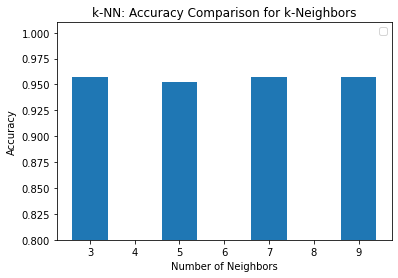

In [ ]:
# KNN plot
plt.title('k-NN: Accuracy Comparison for k-Neighbors')
plt.bar(k_values, final_accs)
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.01)
plt.show()

In [ ]:
#Random Search Parameter Grid for Randsom Forest Hyperparameter Tuning

# Tree count in random forest
n_estimators = [int(x) for x in np.linspace(start = 40, stop = 100, num = 20)]
# feature count for each split
max_features = ['auto', 'sqrt']
# level limit
max_depth = [int(x) for x in np.linspace(40, 100, num = 20)]
# max_depth.append(None)
# sample limit for each node split
min_samples_split = [3, 5, 9]
# sample limit for leaf node
min_samples_leaf = [2, 3, 5]
# selecting smples for training
bootstrap = [True, False]
#random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
#Random Forest Classifier
clf=RandomForestClassifier(n_estimators=100)

rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=1, random_state=20)
# Fit the random search model
rf_random.fit(intermediate_trainX,y_train)

#save model to pickle file
ffname = '1105134-RF.pkl'
pickle.dump(rf_random.best_estimator_, open(ffname, 'wb'))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.9s finished


In [ ]:
# Best rf model
best_rf = rf_random.best_estimator_
best_params = rf_random.best_params_
best_acc = rf_random.best_score_

all_params = rf_random.cv_results_['params']
all_accs = rf_random.cv_results_['mean_test_score']

for a, p in zip(all_accs, all_params):
  print('accuracy', a, 'achieved with params :',p)


accuracy 0.9542857142857143 achieved with params : {'n_estimators': 84, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 68, 'bootstrap': False}
accuracy 0.9504761904761905 achieved with params : {'n_estimators': 62, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 77, 'bootstrap': True}
accuracy 0.958095238095238 achieved with params : {'n_estimators': 74, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}
accuracy 0.9561904761904761 achieved with params : {'n_estimators': 65, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}
accuracy 0.9533333333333333 achieved with params : {'n_estimators': 40, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 58, 'bootstrap': False}
accuracy 0.9504761904761905 achieved with params : {'n_estimators': 87, 'min_samples_split': 3, 'min_s

In [ ]:
#Optimal Hyperparameters in Random Forest

for hp in best_params:
  print('Optimal', hp, 'value:', best_params[hp])

Optimal n_estimators value: 74
Optimal min_samples_split value: 3
Optimal min_samples_leaf value: 2
Optimal max_features value: sqrt
Optimal max_depth value: 40
Optimal bootstrap value: False


In [ ]:
#load RF model
model_rf = pickle.load(open(ffname, 'rb'))

#Testing and predicting
pred_rf = model_rf.predict(intermediate_testX)

#Random Forest Accuracy
from sklearn.metrics import confusion_matrix
accuracy_rf = accuracy_score(y_test, pred_rf)
print("RF Accuracy: ", accuracy_rf)
print()
print('Confusion Matrix: \n', confusion_matrix(y_test, pred_rf))

RF Accuracy:  0.9711111111111111

Confusion Matrix: 
 [[135   0   5]
 [  0 135   2]
 [  6   0 167]]
